In [1]:
"""
This program is written in such a way that for a given perturbation generated for a particular signal
plots will be generated to a specific target class using all the 3 metrics [L2, Dsmooth, DsmoothL2]
Our goal is to verify that all the instances of Table 3 can be generated
"""


from keras.utils import plot_model
import keras.backend as K
import keras
from keras import backend
from keras.models import load_model
from keras.utils.np_utils import to_categorical
from keras import metrics
import tensorflow as tf


Using TensorFlow backend.
/Users/bibekpoudel/Desktop/git/Adversarial_Examples_Results_Reproduction/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/bibekpoudel/Desktop/git/Adversarial_Examples_Results_Reproduction/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/bibekpoudel/Desktop/git/Adversarial_Examples_Results_Reproduction/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of nump

In [2]:
import h5py
from numpy import genfromtxt
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt
import scipy.fftpack
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import os
import glob
import csv
import sys

In [3]:
dataDir = "../training2017/"
folder1 = "./smooth_eval/"
folder2 = "./l2_eval/"
folder3 = "./l2smooth_0_01_eval/"
FS = 300
WINDOW_SIZE = 30*FS     # padding window for CNN
classes = ['A', 'N', 'O','~']

In [4]:
#### Funtion definition
def preprocess(x, maxlen):
    x =  np.nan_to_num(x)
#    x =  x[0, 0:min(maxlen,len(x))]
    x =  x[0, 0:maxlen]
    x = x - np.mean(x)
    x = x / np.std(x)

    tmp = np.zeros((1, maxlen))
    tmp[0, :len(x)] = x.T  # padding sequence
    x = tmp
    x = np.expand_dims(x, axis=2)  # required by Keras
    del tmp

    return x

In [5]:
print("Enter index of signal for which perturbations are generated, in the mat file")
idx = int(input())
print("Enter Ground truth index [A,N,O,~]=[0,1,2,3] for this signal:")
TRUTH = int(input())
g_label = classes[int(TRUTH)]
print("Enter the target class for which you want misclassification to occur [A,N,O,~]=[0,1,2,3]")
TARGET = int(input())
t_label = classes[int(TARGET)]

Enter index of signal for which perturbations are generated, in the mat file
5
Enter Ground truth index [A,N,O,~]=[0,1,2,3] for this signal:
0
Enter the target class for which you want misclassification to occur [A,N,O,~]=[0,1,2,3]
2


In [6]:
record = "A{:05d}".format(idx)
local_filename = dataDir+record
print('Loading record {}'.format(record))
mat_data = scipy.io.loadmat(local_filename)
data = mat_data['val']
data = preprocess(data, WINDOW_SIZE)
sample = np.reshape(data, (9000,1))

Loading record A00005


In [7]:
file1 = glob.glob(folder1 + "R" +  str(idx) + "_" + str(TRUTH) + "_" + str(TARGET) + "_?.csv")[0]
adv_sample_1 = genfromtxt(file1, delimiter=',')
adv_sample_1 = np.reshape(adv_sample_1, (9000,1))
res_1 = file1[-5]
r_label_1 = classes[int(res_1)]
print("The file has been loaded from",folder1)

The file has been loaded from ./smooth_eval/


In [8]:
file2 = glob.glob(folder2 + "R" +  str(idx) + "_" + str(TRUTH) + "_" + str(TARGET) + "_?.csv")[0]
adv_sample_2 = genfromtxt(file2, delimiter=',')
adv_sample_2 = np.reshape(adv_sample_2, (9000,1))
res_2 = file2[-5]
r_label_2 = classes[int(res_2)]
print("The file has been loaded from",folder2)

The file has been loaded from ./l2_eval/


In [9]:
file3 = glob.glob(folder3 + "R" +  str(idx) + "_" + str(TRUTH) + "_" + str(TARGET) + "_?.csv")[0]
adv_sample_3 = genfromtxt(file3, delimiter=',')
adv_sample_3 = np.reshape(adv_sample_3, (9000,1))
res_3 = file3[-5]
r_label_3 = classes[int(res_3)]
print("The file has been loaded from",folder3)

The file has been loaded from ./l2smooth_0_01_eval/


/Users/bibekpoudel/Desktop/git/Adversarial_Examples_Results_Reproduction/env/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


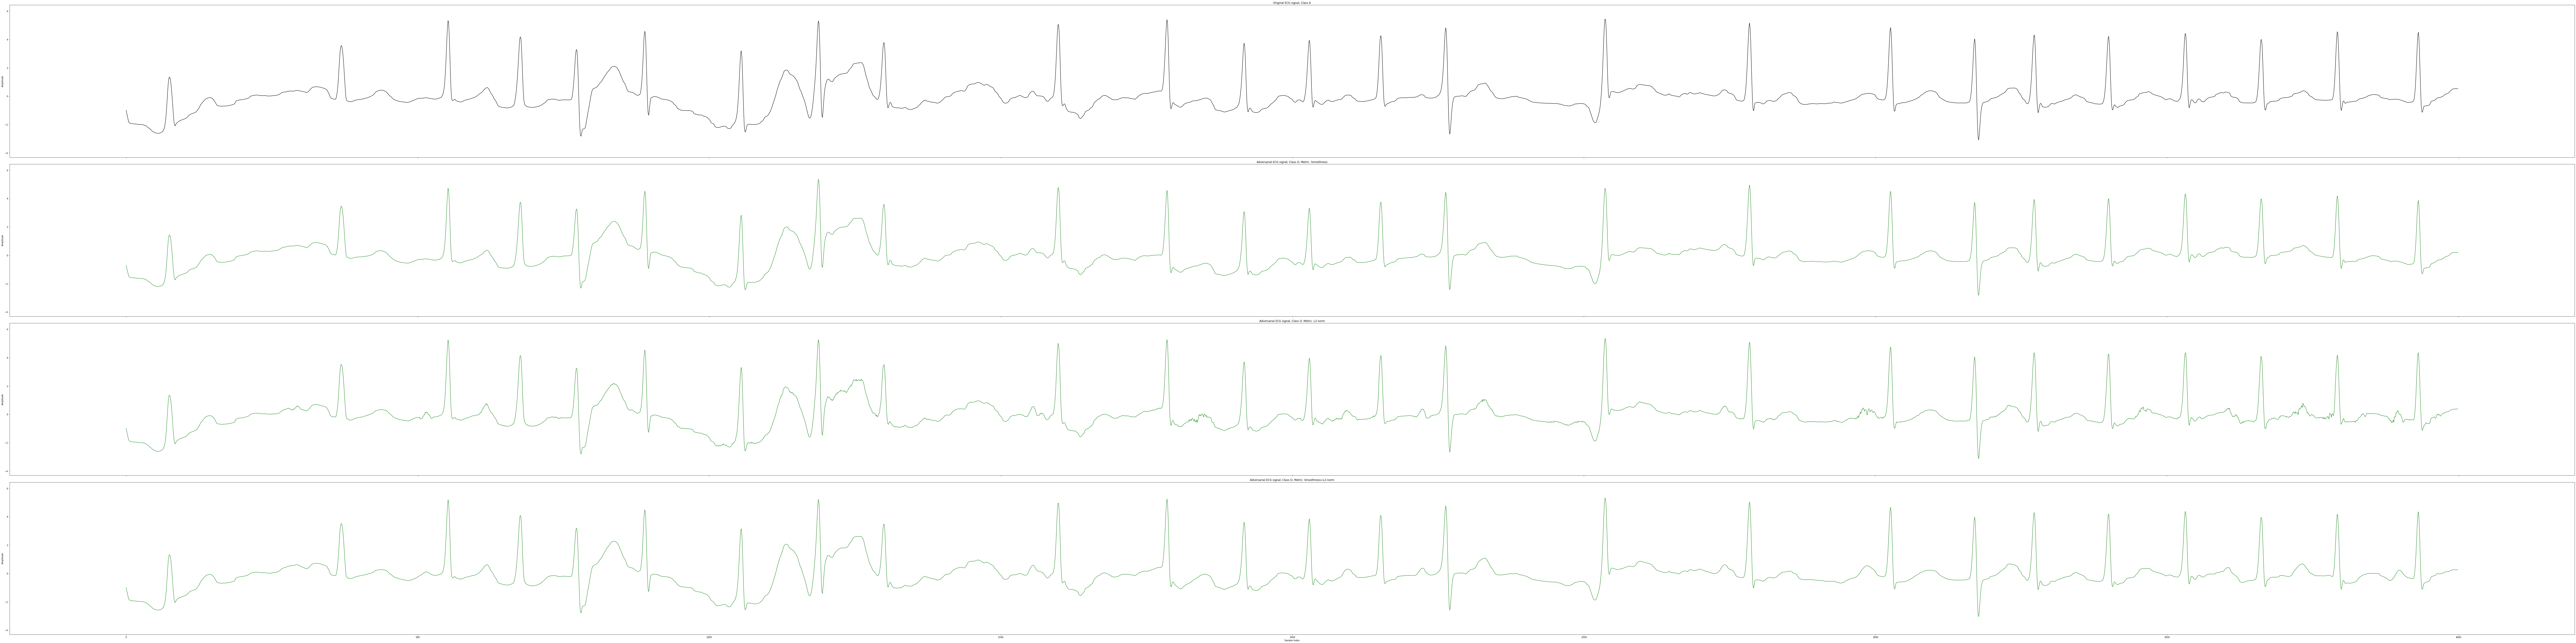

In [10]:
#Original Plot

ymax = np.max([sample, adv_sample_1, adv_sample_2, adv_sample_3])+1
ymin = np.min([sample, adv_sample_1, adv_sample_2, adv_sample_3])-1


fig, axs = plt.subplots(4, 1, figsize=(160,40), sharex=True)

axs[0].plot(sample[0:4000,:], color='black', label='Original signal')
axs[0].set_title('Original ECG signal, Class {}'.format(g_label))
axs[0].set_ylim([ymin, ymax])
axs[0].set_ylabel('Amplitude')

axs[1].plot(adv_sample_1[0:4000,:], color='forestgreen', label='Adv signal_diff')
axs[1].set_title('Adversarial ECG signal, Class {}, Metric: Smoothness'.format(r_label_1))
axs[1].set_ylim([ymin, ymax])
axs[1].set_ylabel('Amplitude')

axs[2].plot(adv_sample_2[0:4000,:], color='forestgreen', label='Adv signal_l2')
axs[2].set_title('Adversarial ECG signal, Class {}, Metric: L2-norm'.format(r_label_1))
axs[2].set_ylim([ymin, ymax])
axs[2].set_ylabel('Amplitude')

axs[3].plot(adv_sample_3[0:4000,:], color='forestgreen', label='Adv signal_l2_diff')
axs[3].set_title('Adversarial ECG signal, Class {}, Metric: Smoothness+L2-norm'.format(r_label_1))
axs[3].set_ylim([ymin, ymax])
axs[3].set_xlabel('Sample Index')
axs[3].set_ylabel('Amplitude')
fig.tight_layout()
fig.show()
plt.show()

In [11]:

"""
Hence, each data point was targeted to 3 other classes (different from the ground truth) with 3 different metrics
So, 9 files are generated for 1 signal

The ground truth of the file loaded here is class A (index 0), the record file is A00005
The adversarial examples are generated as follows: 
For L2 metric: (inside folder l2_eval)
    file R5_0_1_1.csv = AE targeted for class index 1 (Normal Rhythm)
    file R5_0_2_2.csv = AE targeted for class index 2 (Other Rhythm)
    file R5_0_3_3.csv = AE targeted for class index 3 (Noise)
    
For Dsmooth metric: (inside folder smooth_eval)
    file R5_0_1_1.csv = AE targeted for class index 1 (Normal Rhythm)
    file R5_0_2_2.csv = AE targeted for class index 2 (Other Rhythm)
    file R5_0_3_3.csv = AE targeted for class index 3 (Noise)

For DsmoothL2 metric: (inside folder l2smooth_0_01_eval)
    file R5_0_1_1.csv = AE targeted for class index 1 (Normal Rhythm)
    file R5_0_2_2.csv = AE targeted for class index 2 (Other Rhythm)
    file R5_0_3_3.csv = AE targeted for class index 3 (Noise)
    
Lets load the model and verify that they are indeed misclassified.
"""

'\nHence, each data point was targeted to 3 other classes (different from the ground truth) with 3 different metrics\nSo, 9 files are generated for 1 signal\n\nThe ground truth of the file loaded here is class A (index 0), the record file is A00005\nThe adversarial examples are generated as follows: \nFor L2 metric: (inside folder l2_eval)\n    file R5_0_1_1.csv = AE targeted for class index 1 (Normal Rhythm)\n    file R5_0_2_2.csv = AE targeted for class index 2 (Other Rhythm)\n    file R5_0_3_3.csv = AE targeted for class index 3 (Noise)\n    \nFor Dsmooth metric: (inside folder smooth_eval)\n    file R5_0_1_1.csv = AE targeted for class index 1 (Normal Rhythm)\n    file R5_0_2_2.csv = AE targeted for class index 2 (Other Rhythm)\n    file R5_0_3_3.csv = AE targeted for class index 3 (Noise)\n\nFor DsmoothL2 metric: (inside folder l2smooth_0_01_eval)\n    file R5_0_1_1.csv = AE targeted for class index 1 (Normal Rhythm)\n    file R5_0_2_2.csv = AE targeted for class index 2 (Other Rh

In [12]:
from keras.models import load_model

In [13]:
#pre-processing required before applying model 

def preprocess(x, maxlen):
    
    #Replace any 'not a number with a zero and infinity'
    x =  np.nan_to_num(x)
    
    # The value of maxlen is set to 9000 before passing to the function
    # Clip the data at 9000 points, new size of data is 1x9000 if the size of x > 9000
    # But this is adaptive, if the length of x is less than 9000, it retains original size
    # This also converts x from a 2d array to 1d
    
    x =  x[0, 0:maxlen]
    #x =  x[0:maxlen]
    
    # Standard Scaling (mean and std of this particular data for each)
    x = x - np.mean(x)
    x = x / np.std(x)

    # init a 2D array of size 1x9000
    tmp = np.zeros((1, maxlen))
    
    # copy the contents of x to tmp
    # but tmp here is 2D array
    # what is the meaning of padding sequence?
    tmp[0, :len(x)] = x.T  # padding sequence
    
    # convert x back to 2D array with scaled contents
    x = tmp
    
    # This is the most strange step, they say it is required by keras
    # They convert the scaled x values to a 3D array (axis =2)
    # With values written as [[[0.7],[0.6],[0.4],....]]
    x = np.expand_dims(x, axis=2)  # required by Keras
    
    #delete temp
    del tmp
    
    return x

def predict_data(model,x):
    
    # The model expects a numpy array as a input (Keras)
    # The output that the predict function returns is a list of probabilities of all 4 classes
    prob = model.predict(x)
    
    # Returns an index of the max value in an array
    ann = np.argmax(prob)
    
    return prob,ann

In [14]:
print("Loading model")    
model = load_model("../ResNet_30s_34lay_16conv.hdf5")

Loading model


/Users/bibekpoudel/Desktop/git/Adversarial_Examples_Results_Reproduction/env/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [22]:
# Lets load the 9 files
# Since R5 did not work for L2, I used R9 But that did not work as well

f1 = glob.glob(folder2 + "R" +  "5" + "_" + "0" + "_" + "1" + "_?.csv")[0]
l2_normal = genfromtxt(f1, delimiter=',')
l2_normal = np.reshape(l2_normal, (1,9000))

f2 = glob.glob(folder2 + "R" +  "5" + "_" + "0" + "_" + "2" + "_?.csv")[0]
l2_other = genfromtxt(f2, delimiter=',')
l2_other = np.reshape(l2_other, (1,9000))

f3 = glob.glob(folder2 + "R" +  "5" + "_" + "0" + "_" + "3" + "_?.csv")[0]
l2_noise = genfromtxt(f3, delimiter=',')
l2_noise = np.reshape(l2_noise, (1,9000))

f4 = glob.glob(folder1 + "R" +  "5" + "_" + "0" + "_" + "1" + "_?.csv")[0]
smooth_normal = genfromtxt(f4, delimiter=',')
smooth_normal = np.reshape(smooth_normal, (1,9000))

f5 = glob.glob(folder1 + "R" +  "5" + "_" + "0" + "_" + "2" + "_?.csv")[0]
smooth_other = genfromtxt(f5, delimiter=',')
smooth_other = np.reshape(smooth_other, (1,9000))

f6 = glob.glob(folder1 + "R" +  "5" + "_" + "0" + "_" + "3" + "_?.csv")[0]
smooth_noise = genfromtxt(f6, delimiter=',')
smooth_noise = np.reshape(smooth_noise, (1,9000))

f7 = glob.glob(folder3 + "R" +  "5" + "_" + "0" + "_" + "1" + "_?.csv")[0]
smooth_l2_normal = genfromtxt(f7, delimiter=',')
smooth_l2_normal = np.reshape(smooth_l2_normal, (1,9000))

f8 = glob.glob(folder3 + "R" +  "5" + "_" + "0" + "_" + "2" + "_?.csv")[0]
smooth_l2_other = genfromtxt(f8, delimiter=',')
smooth_l2_other = np.reshape(smooth_l2_other, (1,9000))

f9 = glob.glob(folder3 + "R" +  "5" + "_" + "0" + "_" + "3" + "_?.csv")[0]
smooth_l2_noise = genfromtxt(f9, delimiter=',')
smooth_l2_noise = np.reshape(smooth_l2_noise, (1,9000))

In [23]:
l2_normal_new = preprocess(l2_normal, 9000)
l2_other_new = preprocess(l2_other, 9000)
l2_noise_new = preprocess(l2_noise, 9000)

smooth_normal_new = preprocess(smooth_normal, 9000)
smooth_other_new = preprocess(smooth_other, 9000)
smooth_noise_new = preprocess(smooth_noise, 9000)

smooth_l2_normal_new = preprocess(smooth_l2_normal, 9000)
smooth_l2_other_new = preprocess(smooth_l2_other, 9000)
smooth_l2_noise_new = preprocess(smooth_l2_noise, 9000)

In [24]:
classes = ['A', 'N', 'O','~']
prob_1,a1 = predict_data(model,l2_normal_new)
prob_2,a2 = predict_data(model,l2_other_new)
prob_3,a3 = predict_data(model,l2_noise_new)

prob_4,a4 = predict_data(model,smooth_normal_new)
prob_5,a5 = predict_data(model,smooth_other_new)
prob_6,a6 = predict_data(model,smooth_noise_new)

prob_7,a7 = predict_data(model,smooth_l2_normal_new)
prob_8,a8 = predict_data(model,smooth_l2_other_new)
prob_9,a9 = predict_data(model,smooth_l2_noise_new)

In [25]:
print(classes[a1])
print(classes[a2])
print(classes[a3])

print(classes[a4])
print(classes[a5])
print(classes[a6])

print(classes[a7])
print(classes[a8])
print(classes[a9])

O
A
O
N
O
~
N
O
~


In [19]:
"""
Hence, we verified the Adversarial Examples for 6 records (except L2)
As we can see not all of them are working as expected
"""

'\nHence, we verified the Adversarial Examples\nAs we can see not all of them are working as expected\n'

In [20]:
def plot_ECG(data):
    x_axis = np.linspace(0.,9000.,num=9000)
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(16,5))
    plt.plot(x_axis, data,'r')
    plt.axis([0, 9000,-10, 10])
    #plt.title(class_name)
    plt.ylabel('milli Volts')
    plt.xlabel('Time (in seconds)')
    plt.tight_layout()
    plt.show()

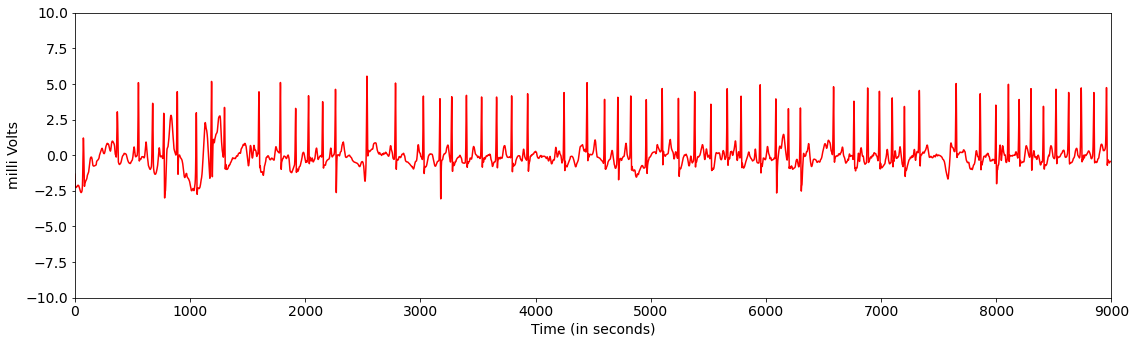

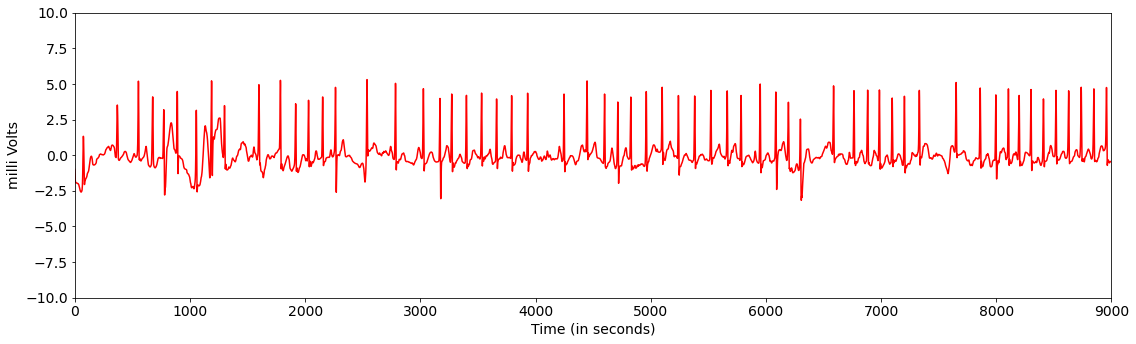

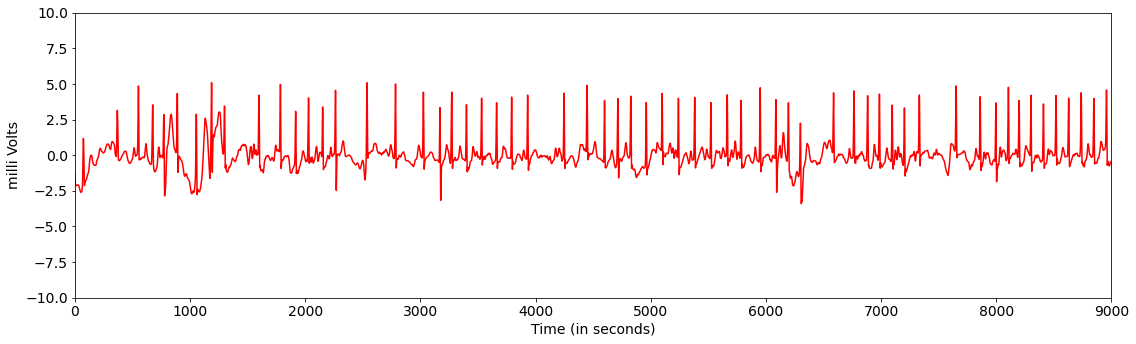

In [26]:
plot_ECG(smooth_l2_normal[0])
plot_ECG(smooth_l2_other[0])
plot_ECG(smooth_l2_noise[0])